# Project 3: Histopathologic Cancer Detection

## Step 1: Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from glob import glob


## Step 2: Load the data and add labels

In [2]:
import pandas as pd

#load labels
labels_path = "histopathologic-cancer-detection/train_labels.csv"
df = pd.read_csv(labels_path)

#verify data
print(df.head())

# split data
benign_files = df[df['label'] == 0]['id'].values
malignant_files = df[df['label'] == 1]['id'].values

# full paths
train_path = "histopathologic-cancer-detection/train/"
benign_paths = [train_path + f"{img_id}.tif" for img_id in benign_files]
malignant_paths = [train_path + f"{img_id}.tif" for img_id in malignant_files]

print(f"Benign images: {len(benign_paths)}, Malignant images: {len(malignant_paths)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Benign images: 130908, Malignant images: 89117


## Step 3: Visualize the data

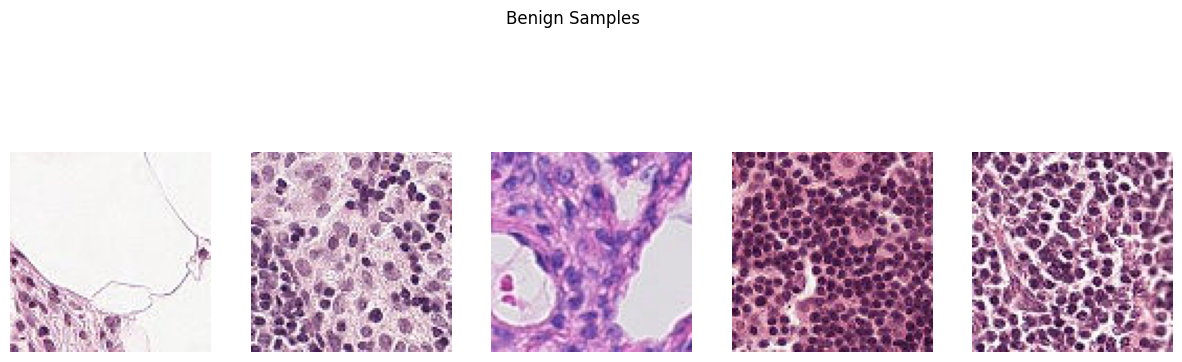

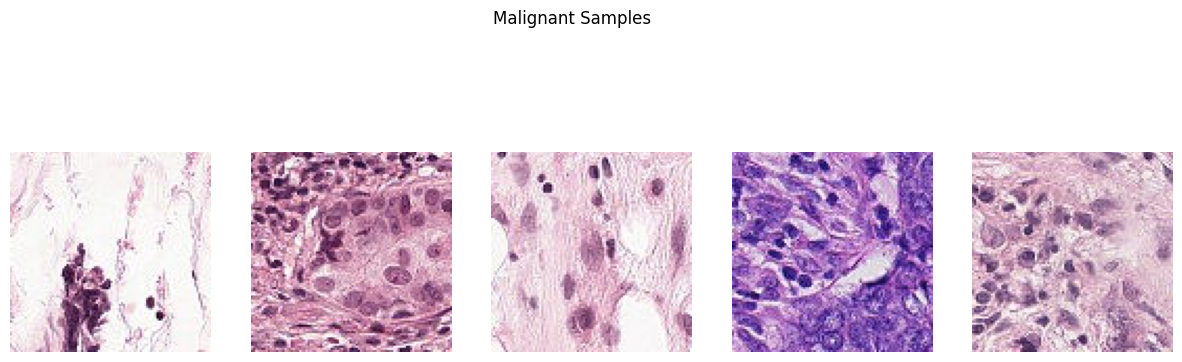

In [3]:
import matplotlib.pyplot as plt
import cv2

def show_samples(image_paths, title, num=5):
    fig, axes = plt.subplots(1, num, figsize=(15, 5))
    for i, path in enumerate(image_paths[:num]):
        img = cv2.imread(path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# visualize samples
show_samples(benign_paths, "Benign Samples")
show_samples(malignant_paths, "Malignant Samples")


## Step 4: Preprocess the data

In [4]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# preprocess images
def load_images(image_paths, label, num_samples=5000, img_size=(96, 96)):
    images, labels = [], []
    for path in image_paths[:num_samples]: 
        img = load_img(path, target_size=img_size)  
        img = img_to_array(img) / 255.0  
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# create benign and malignant images
benign_images, benign_labels = load_images(benign_paths, label=0, num_samples=5000)
malignant_images, malignant_labels = load_images(malignant_paths, label=1, num_samples=5000)

X = np.concatenate((benign_images, malignant_images), axis=0)
y = np.concatenate((benign_labels, malignant_labels), axis=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (8000, 96, 96, 3), Validation set: (2000, 96, 96, 3)


## Step 5: Create and train the model

In [5]:
# create the model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005), input_shape=(96, 96, 3)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    Dropout(0.6),  # Increased dropout to prevent memorization
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]


history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save Model
model.save("tumor_detection_cnn_v3.h5")

/opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 172ms/step - accuracy: 0.6978 - loss: 1.0765 - val_accuracy: 0.6090 - val_loss: 1.3092 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.7725 - loss: 0.8678 - val_accuracy: 0.6845 - val_loss: 1.1152 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.7963 - loss: 0.8089 - val_accuracy: 0.7490 - val_loss: 0.9118 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 152ms/step - accuracy: 0.8053 - loss: 0.7864 - val_accuracy: 0.7595 - val_loss: 0.8842 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.8094 - loss: 0.7659 - val_accuracy: 0.7885 - val_loss: 0.7954 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.8182 - loss: 0.7397 - val_accuracy: 0.7615 - val_loss: 0.7898 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 16

## Step 6: Test the model

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Accuracy: 0.8405
Precision: 0.8689
Recall: 0.8020
F1 Score: 0.8341
              precision    recall  f1-score   support

      Benign       0.82      0.88      0.85      1000
   Malignant       0.87      0.80      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



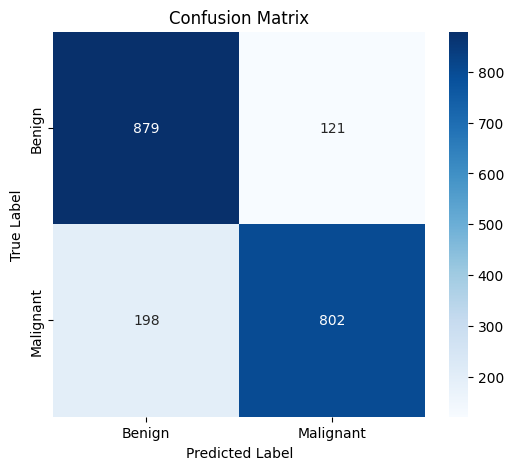

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model_path, X_test, y_test):
    model = tf.keras.models.load_model(model_path)

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)  

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


evaluate_model("tumor_detection_cnn_v3.h5", X_val, y_val)